---
title: "Coordinate System"
format: 
    html:
        toc: true 
        code-fold: false
execute:
    eval: False
    warning: False
jupyter: python3
bibliography: [../references.bib]
---

In [1]:
import os
import caveclient
try:
    os.makedirs('~/.cloudvolume/secrets')
except:
    pass
cglob = caveclient.CAVEclient(global_only=True)
cglob.auth.save_token(token=os.environ.get('API_SECRET'), overwrite=True)
del cglob

## Introduction

Because of the many different data representations, dealing with coordinates in the MICrONs data is not entirely simple and it is easy to make mistakes by converting between coordinate systems incorrectly.

There are three main coordinate systems that wind up getting used:

1. **Voxel coordinates** are the coordinates of a point in the original image volume.
These are the coordinates that are used to index into the volumes you can see in Neuroglancer, but each number has a potentially different unit.
In the MICrONs data, a voxel is 4 nm wide in the x and y directions, and 40 nm long in the z direction.
This means that a 1x1x1 micron cube would be represented by a 250x250x25 voxel span.
*Annotations* (such as synapses) are stored in voxel coordinates.

2. **Nanometer coordinates** are the coordinates of a point in the original image volume, but in nanometers.
This is equivalent to the voxel coordinate multiplied by the voxel resolution, with no further transformation applied.
*Mesh and skeleton vertices* are stored in nanometer coordinates.

3. **Transformed coordinates** reflect a trasnsformation that has been applied to the original image volume.
This transformation is a rotation to make the pia surface as flat as possible, a translation to move the pial surface to y=0, and a scaling to bring coordinates into microns.
Transformed coordinates are convenient for more accurate computations of depth and the pia-to-white-matter axis, but are not stored by default.
A python package `standard_transform` helps convert data to and from transformed coordinates.

::: {.callout-note}
Note that in all of these coordinate systems (including Neuroglancer), the y axis *increases* with depth. This is a standard definition when working with images, but is the opposite of what you usually think of with points.
Because of that, when plotting annotations or neuroanatomy in matplotlib, you will usually have to invert the y axis with `ax.invert_yaxis()`.
:::

## Standard Transform

[Standard Transform](https://github.com/ceesem/standard_transform) is a python package designed to convert voxel and nanometer coordinates to transformed coordinates, with particular emphasis on the MICrONs data.

### Installation

Standard Transform can be installed from pip: `pip install standard_transform`

### Why use Standard Transform?

Let's look at the coordinates of every excitatory neuron in the MICrONs data to see why we might want to use transformed coordinates.

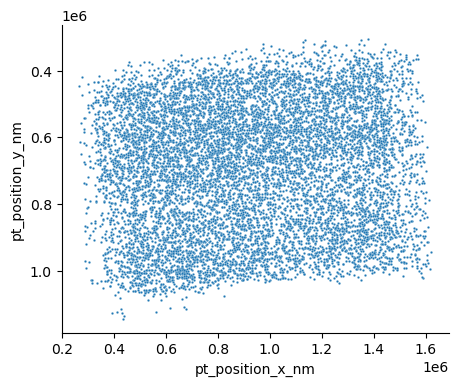

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
from caveclient import CAVEclient

client = CAVEclient('minnie65_public')

ct_df = client.materialize.query_table('aibs_soma_nuc_metamodel_preds_v117', split_positions=True)

# convert to nanometers
ct_df['pt_position_x_nm'] = ct_df['pt_position_x'] * 4
ct_df['pt_position_y_nm'] = ct_df['pt_position_y'] * 4
ct_df['pt_position_z_nm'] = ct_df['pt_position_z'] * 40

fig, ax = plt.subplots(figsize=(5,4))
sns.scatterplot(
    x='pt_position_x_nm',
    y='pt_position_y_nm',
    s=3,
    data=ct_df.sample(10_000), # Pick a random sample of 10,000 points, enough to see the shape of the data.
    ax=ax,
)

# Important to flip the y axis to have y increase with depth!
ax.invert_yaxis()
sns.despine(ax=ax)

This is just the raw positions, converted to nanometers.
You can see a few aspects that might make this hard to work with.

First, if you look along the top of the data, you can see that the pia surface is not flat.
In fact, there's a roughly 5 degree slope from the left to the right.
Second, if you look at the location of the pia surface, it's at around y = 0.4 * 10^6.

Not only are these units large, the offset is arbitrary and it would make much more sense to anchor y=0 to the pial surface.

Let's see how we can do this with `standard_transform`.

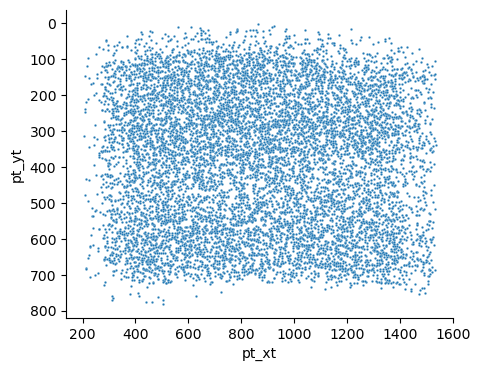

In [3]:
from standard_transform import minnie_ds
import numpy as np

X_transformed = minnie_ds.transform_vx.apply_dataframe('pt_position', ct_df)
X_transformed = np.array(X_transformed)
ct_df['pt_xt'] = X_transformed[:,0]
ct_df['pt_yt'] = X_transformed[:,1]
ct_df['pt_zt'] = X_transformed[:,2] 

fig, ax = plt.subplots(figsize=(5,4))

sns.scatterplot(
    x='pt_xt',
    y='pt_yt',
    s=3,
    data=ct_df.sample(10_000),
    ax=ax,
)

ax.invert_yaxis()
sns.despine(ax=ax)

Now you can see that the surface is much more aligned with the x-axis, and the cells in layer 1 start just below y=0.
In addition, the units have been converted to microns, which is much more readable and more consistent with measurements in other modalities.

### How to use Standard Transform.

A number of examples are available in the [standard_transform readme](https://github.com/ceesem/standard_transform).

#### Transforming points

The main functions when working with point data are `transform_vx` and `transform_nm`, which transform from voxel coordinates and from nanometer coordinates respectively.
In the above example, you will note that because we were working with annotations, we used the voxel coordinate transform.

Each of the two transforms has the same functions that can be used:

* `minnie_ds.{transform}.apply(x)`: This converts an `Nx3` array of points from the original space to an `Nx3` array of transformed coordinates.
* `minnie_ds.{transform}.apply_project(projection_axis, x)`: This converts an `Nx3` array of points from the original space to an `N`-length array of transformed coordinates, taking only values along the given axis (`x`, `y`, or `z`). This is typically done along the `y` axis to get the depth of each point.
* `minnie_ds.{transform}.apply_dataframe(column_name, df, Optional[projection_axis])`: This takes points from a dataframe column (or collection of three dataframe columns named `{column_name}_x`, `{column_name}_y`, and `{column_name}_z`) and converts them to transformed coordinates. If `projection_axis` is given, it will only return the values along that axis.

Where `{transform}` is either `transform_vx` or `transform_nm`.

You can also invert a transformation, for example if you want to convert transformed coordinates back to voxel coordinates to view in Neuroglancer.

* `minnie_ds.{transform}.invert(X)`: This maps from an Nx3 array in the *transformed space* back to the original space (voxel or nanometer coordiantes, depending on which transform you used).

#### Transforming meshes and skeletons

Standard transform has the capability to transform MeshParty skeletons, MeshWorks, and MeshWork annotations using these same transforms as above.

For example, to transform all the vertices of meshwork object:

In [5]:
nrn_transformed = minnie_ds.transform_nm.apply_meshwork_vertices(nrn)

However, Meshwork objects also have annotations in dataframes as well as vertices.
In order to transform these points, we need to specify both the name of the dataframe table and the columns to transform as a dictionary.
For example, if you want to also remap the `ctr_pt_position` values from the `pre_syn` table and `post_syn` tables (which are in voxels by default), you would use:

In [ ]:
anno_dict={'pre_syn': 'ctr_pt_position', 'post_syn': 'ctr_pt_position'}
nrn_transformed = minnie_ds.transform_vx.apply_meshwork_annotations(nrn_transformed, anno_dict, inplace=True)

Note that without the `inplace=True` parameter, these meshwork transformations will return a new object, while if`inplace=True` the original object is modified.